# Model Building

In [ ]:
# import packages

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sqlite3

In [ ]:
df_bikes_yelp = pd.read_csv('bikes_yelp.csv')

### Exploring the combined dataframe:

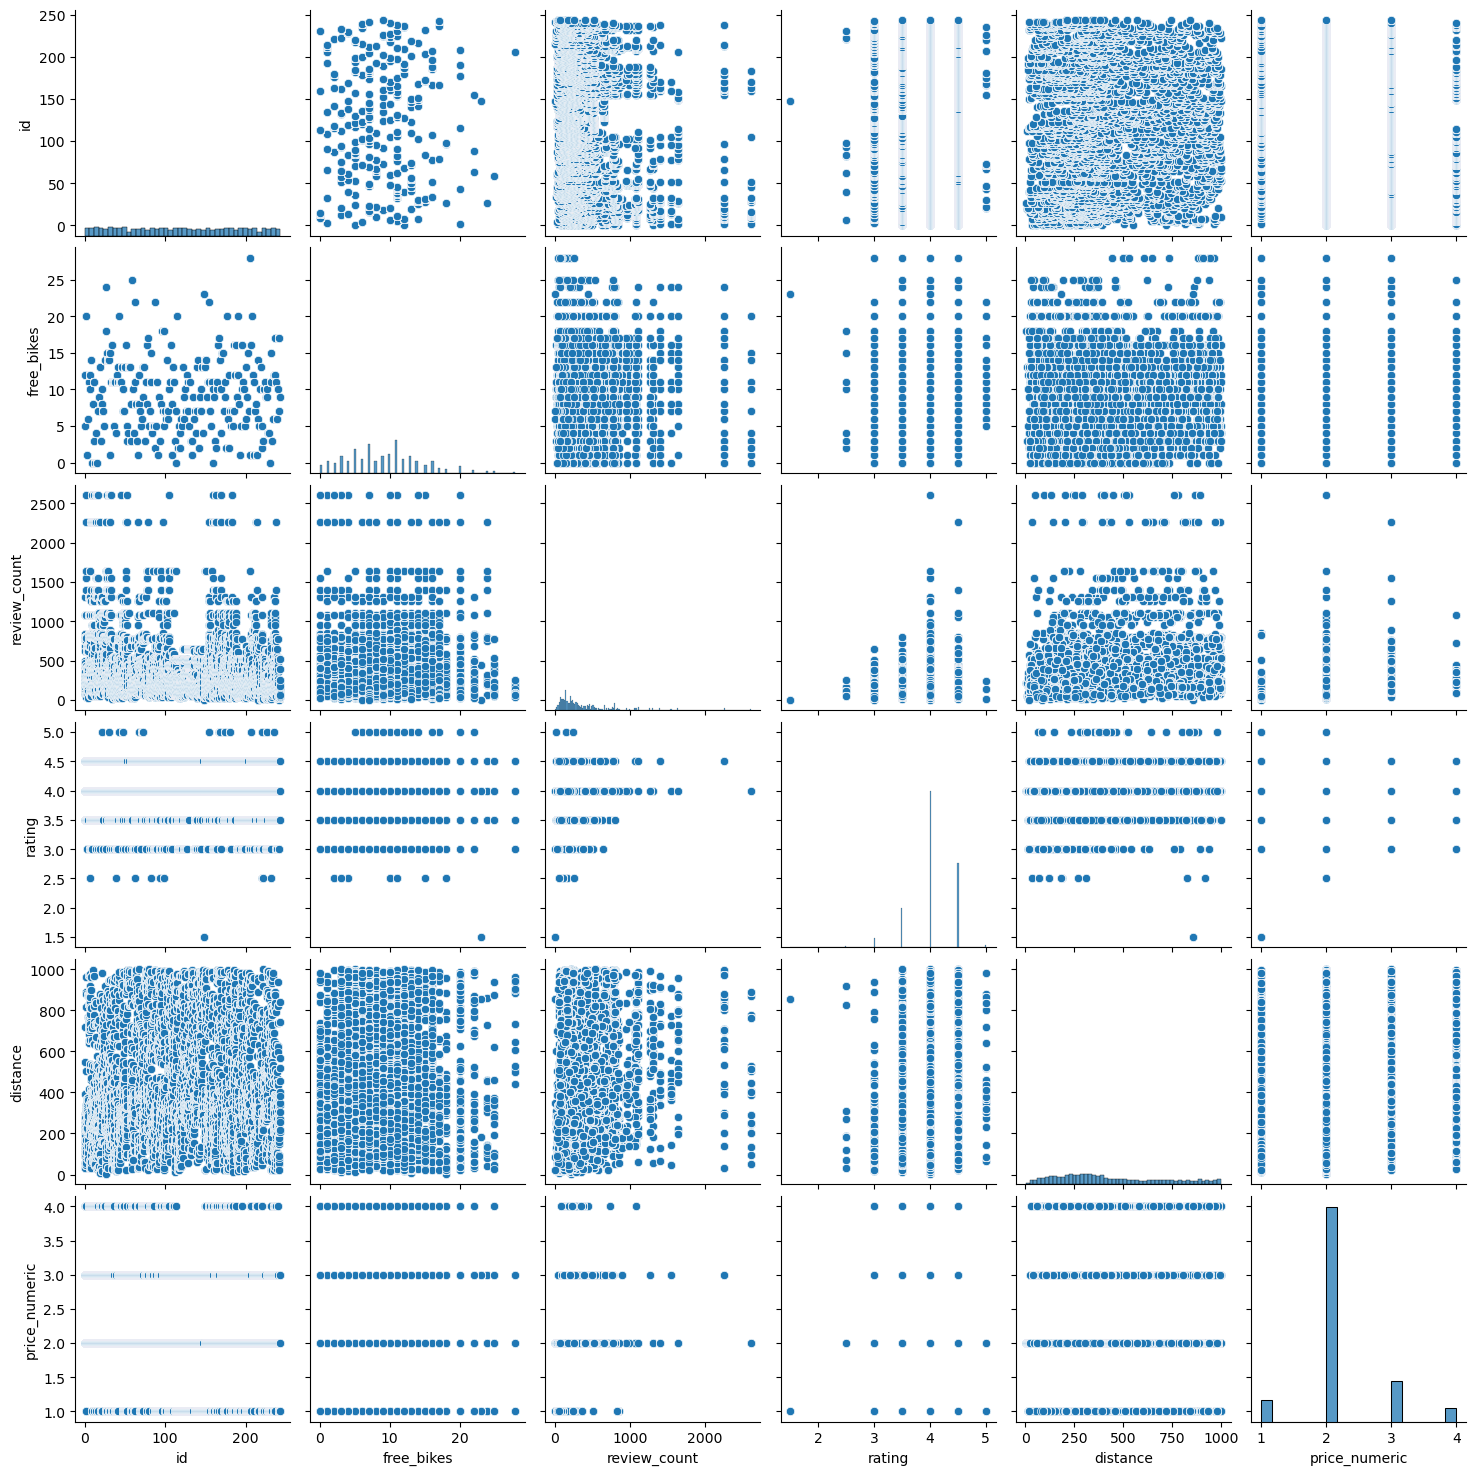

In [29]:
sns.pairplot(df_bikes_yelp)
plt.show()

It doesn't seem to be any pattern or correlation between the variables.

Our dependent variable will be 'free_bikes'. Let's run a correlation matrix and see the behaviour with the independent variables:

In [30]:
corr_matrix = df_bikes_yelp.corr()
corr_matrix

,id,free_bikes,review_count,rating,distance,price_numeric
id,1.000000,-0.006775,-0.178954,-0.058842,0.049088,-0.129188
free_bikes,-0.006775,1.000000,0.020645,0.068038,0.085448,-0.008444
review_count,-0.178954,0.020645,1.000000,0.146892,0.200693,0.160522
rating,-0.058842,0.068038,0.146892,1.000000,0.265248,0.078725
distance,0.049088,0.085448,0.200693,0.265248,1.000000,0.068156
price_numeric,-0.129188,-0.008444,0.160522,0.078725,0.068156,1.000000


Very low correlations between the variables. The best one so far is 'distance' with 0.08

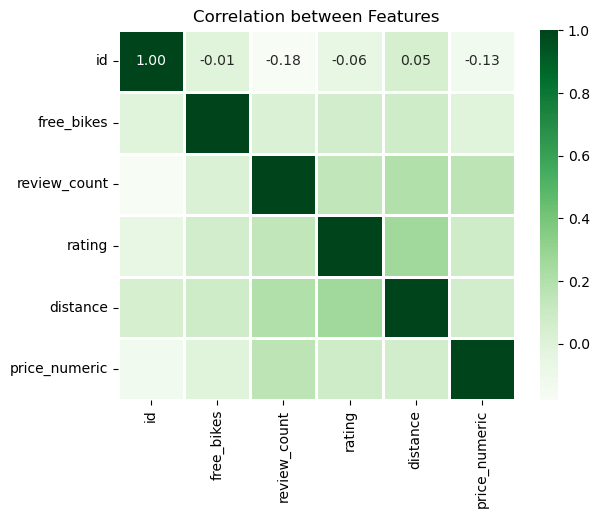

In [31]:
sns.heatmap(corr_matrix, annot=True,cmap="Greens", linewidths=0.75, fmt=".2f")

plt.title('Correlation between Features')

plt.show()

My environment has some erros with the Seaborn package, but when running in a friend's computer, it ran properly. Will add a picture to the repo.

# ---------------------------------------------------------------------------------------------------------------

# Regression model

### 1) Forward Selection

In [32]:
y = df_bikes_yelp['free_bikes']

In [33]:
# Create the constant column:

X = [sm.add_constant(df_bikes_yelp[column]) for column in df_bikes_yelp.columns[1:]] 
X[0]

,const,free_bikes
0,1.0,12
1,1.0,12
2,1.0,12
3,1.0,12
4,1.0,12
...,...,...
78006,1.0,9
78007,1.0,9
78008,1.0,9
78009,1.0,9


In [ ]:
# Will use the OLS with the list of models. Then fit those models and ask for the adjusted R2 and p-values, for each column:

Models = [sm.OLS(y,x) for x in X]

Results = [model.fit() for model in Models]

Adj_Rsquared = [results.rsquared_adj for results in Results] 

Pval = [results.pvalues for results in Results] 

In [35]:
# Print the results: 

for i in range(len(Adj_Rsquared)):
     print(f'adj_R2: {Adj_Rsquared[i]:.3f}, P-values: {*Pval[i],}, column: {df_bikes_yelp.columns[i+1]}')

adj_R2: 1.000, P-values: (0.0, 0.0), column: free_bikes
adj_R2: 0.000, P-values: (0.0, 8.083635508239364e-09), column: review_count
adj_R2: 0.005, P-values: (1.554804111155216e-152, 1.0571119635434406e-80), column: rating
adj_R2: 0.007, P-values: (0.0, 2.4438018065335527e-126), column: distance
adj_R2: 0.000, P-values: (0.0, 0.018345649492593322), column: price_numeric


In [36]:
# 'Distance' was the performer. I'll remove it from the dataframe because I'll continue working with it:

remaining_var = df_bikes_yelp.drop(['free_bikes', 'distance'], axis=1)
remaining_var.head()

,id,review_count,rating,price_numeric
0,0,685,4.0,2
1,0,234,4.5,2
2,0,289,4.0,2
3,0,117,4.5,3
4,0,226,4.0,2


In [37]:
# Add 'distance' into my list of variables that will be included in the final model:

included_df = df_bikes_yelp[['distance']]
included_df

,distance
0,169.517456
1,178.845344
2,102.329817
3,152.157897
4,191.044234
...,...
78006,569.394966
78007,744.999190
78008,842.112588
78009,381.561636


In [38]:
# Now, I'll repeat the same process until I don't see any significant improve in R2 or all p-values are over 0.05:

X = [sm.add_constant(pd.merge(included_df,remaining_var[column], right_index = True, left_index = True)) for column in remaining_var.columns] 
X[2]

,const,distance,rating
0,1.0,169.517456,4.0
1,1.0,178.845344,4.5
2,1.0,102.329817,4.0
3,1.0,152.157897,4.5
4,1.0,191.044234,4.0
...,...,...,...
78006,1.0,569.394966,4.0
78007,1.0,744.999190,4.0
78008,1.0,842.112588,4.5
78009,1.0,381.561636,4.0


In [39]:
Models = [sm.OLS(y,x) for x in X]

Results = [model.fit() for model in Models]

Adj_Rsquared = [results.rsquared_adj for results in Results] 

Pval = [results.pvalues for results in Results] 

for i in range(len(Adj_Rsquared)):
     print(f'adj_R2: {Adj_Rsquared[i]:.3f}, P-values: {*Pval[i],}, column: {remaining_var.columns[i]}')

adj_R2: 0.007, P-values: (0.0, 1.2784083438954639e-127, 0.0020788924940699106), column: id
adj_R2: 0.007, P-values: (0.0, 2.5470611572802854e-119, 0.31713909150176545), column: review_count
adj_R2: 0.009, P-values: (1.7917150170641258e-177, 1.745092760440433e-85, 8.886395767664012e-40), column: rating
adj_R2: 0.007, P-values: (0.0, 1.2683050659837937e-128, 6.091345590842763e-05), column: price_numeric


In [40]:
remaining_var = df_bikes_yelp.drop(['free_bikes', 'distance', 'rating'], axis=1)
included_df = df_bikes_yelp[['distance', 'rating']]

In [41]:
X = [sm.add_constant(pd.merge(included_df,remaining_var[column], right_index = True, left_index = True)) for column in remaining_var.columns] 
X[2]

,const,distance,rating,price_numeric
0,1.0,169.517456,4.0,2
1,1.0,178.845344,4.5,2
2,1.0,102.329817,4.0,2
3,1.0,152.157897,4.5,3
4,1.0,191.044234,4.0,2
...,...,...,...,...
78006,1.0,569.394966,4.0,2
78007,1.0,744.999190,4.0,2
78008,1.0,842.112588,4.5,1
78009,1.0,381.561636,4.0,2


In [42]:
Models = [sm.OLS(y,x) for x in X]

Results = [model.fit() for model in Models]

Adj_Rsquared = [results.rsquared_adj for results in Results] 

Pval = [results.pvalues for results in Results] 

for i in range(len(Adj_Rsquared)):
     print(f'adj_R2: {Adj_Rsquared[i]:.3f}, P-values: {*Pval[i],}, column: {remaining_var.columns[i]}')

adj_R2: 0.010, P-values: (1.1522099420673162e-174, 2.5824784278958144e-86, 1.1321173225676853e-38, 0.03551339529591508), column: id
adj_R2: 0.009, P-values: (4.027004467788373e-177, 1.5858504895961027e-83, 1.4022416722379236e-39, 0.7569049437549251), column: review_count
adj_R2: 0.010, P-values: (2.3561479938926994e-181, 2.3936922464086697e-87, 2.0406132645096494e-41, 1.1969856147375724e-06), column: price_numeric


In [43]:
remaining_var = df_bikes_yelp.drop(['free_bikes', 'distance', 'rating', 'price_numeric'], axis=1)
included_df = df_bikes_yelp[['distance', 'rating', 'price_numeric']]

In [44]:
X = [sm.add_constant(pd.merge(included_df,remaining_var[column], right_index = True, left_index = True)) for column in remaining_var.columns] 
X[0]

,const,distance,rating,price_numeric,id
0,1.0,169.517456,4.0,2,0
1,1.0,178.845344,4.5,2,0
2,1.0,102.329817,4.0,2,0
3,1.0,152.157897,4.5,3,0
4,1.0,191.044234,4.0,2,0
...,...,...,...,...,...
78006,1.0,569.394966,4.0,2,243
78007,1.0,744.999190,4.0,2,243
78008,1.0,842.112588,4.5,1,243
78009,1.0,381.561636,4.0,2,243


In [45]:
Models = [sm.OLS(y,x) for x in X]

Results = [model.fit() for model in Models]

Adj_Rsquared = [results.rsquared_adj for results in Results] 

Pval = [results.pvalues for results in Results] 

for i in range(len(Adj_Rsquared)):
     print(f'adj_R2: {Adj_Rsquared[i]:.3f}, P-values: {*Pval[i],}, column: {remaining_var.columns[i]}')

adj_R2: 0.010, P-values: (6.45960557049194e-179, 1.2135915250341198e-88, 3.6085381381138955e-40, 2.334751360257659e-07, 0.0059264739722391605), column: id
adj_R2: 0.010, P-values: (8.324069278792984e-181, 1.7107161270607975e-84, 7.070183820462812e-41, 1.1584918953080465e-06, 0.6900599319975925), column: review_count


In [46]:
included_df

,distance,rating,price_numeric
0,169.517456,4.0,2
1,178.845344,4.5,2
2,102.329817,4.0,2
3,152.157897,4.5,3
4,191.044234,4.0,2
...,...,...,...
78006,569.394966,4.0,2
78007,744.999190,4.0,2
78008,842.112588,4.5,1
78009,381.561636,4.0,2


#### 'Distance', 'Rating', 'Price' are the variables that best fit this model. However the Adjusted R2 is pretty low at 0.010

---------------

### 2) Backward Selection

In [47]:
# Firstly, I will run the full model:

y = df_bikes_yelp['free_bikes']
X = df_bikes_yelp.drop('free_bikes', axis=1)
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             free_bikes   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     156.2
Date:                Sun, 19 Nov 2023   Prob (F-statistic):          1.08e-165
Time:                        19:24:33   Log-Likelihood:            -2.4059e+05
No. Observations:               78011   AIC:                         4.812e+05
Df Residuals:                   78005   BIC:                         4.812e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.1336      0.215     28.582

In [48]:
# Remove 'review_count' as its p-value is larger than 0.05

In [49]:
y = df_bikes_yelp['free_bikes']
X = df_bikes_yelp.drop(['free_bikes','review_count'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(y.astype(float), X.astype(float)) #instantiate
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             free_bikes   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     195.2
Date:                Sun, 19 Nov 2023   Prob (F-statistic):          7.30e-167
Time:                        19:24:33   Log-Likelihood:            -2.4059e+05
No. Observations:               78011   AIC:                         4.812e+05
Df Residuals:                   78006   BIC:                         4.812e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.1340      0.215     28.595

#### I arrived to the same model as with forward selection

#### 'Distance', 'Rating', 'Price' will be the variables for this model. The Adjusted R2 still very low at 0.010